# Nanopore Analysis Code
#### Ahmet Ata Ersoy | 09.17.2022

In [1]:
# Import Numpy and Pandas. Check version.
import pandas as pd
import numpy as np
import matplotlib.pyplot
import re
plt = matplotlib.pyplot
import statistics as stat
import seaborn as sns
import os
path = os.getcwd()
from collections import namedtuple

print('matplotlib:', matplotlib.__version__)
print('Pandas:', pd.__version__)
print('Numpy:',np.__version__)
print('Current Path:', path)

matplotlib: 3.3.4
Pandas: 1.2.4
Numpy: 1.20.1
Current Path: C:\Users\ataer\Nanopore


#### READ DATA

In [11]:
class UpperClass( object ):
    pass
class FileInfoClass( UpperClass ):
    def __init__(self,data,AppliedVoltage,BassalFilter,PDC,SamplingRate):
        self.data = data
        self.AppliedVoltage = AppliedVoltage
        self.BassalFilter = BassalFilter
        self.PDC = PDC
        self.SamplingRate = SamplingRate
        pass

# FUNCTION 
# Function to sum all data together. 
def combine_data(var, Extracted_Data):
    data = []
    for i  in range(len(var)):
        data.append(getattr(Extracted_Data, var[i]).data)
        appended_data= pd.concat(data)
    return appended_data

Extracted_Data = UpperClass()

Tf = [f for f in os.listdir(path) if f.endswith('.xlsx')]
var = list()
appended_data = []
for file in Tf: 
    vs = file.split('_')
    data = pd.read_excel(file)
    SamplingRate = int(re.findall(r'\d+',[i for i in vs if (i.endswith('kHz') & (i.startswith('s')))][0])[0])
    var.append('File'+re.findall(r'\d+\.?\d+?', [i for i in vs if i.startswith('File')][0])[0].replace('.','_'))
    BassalFilter = int(re.findall(r'\d+',[i for i in vs if i.endswith('kHz')][0])[0])
    AppliedVoltage = int(re.findall(r'\d+',[i for i in vs if i.endswith('mV')][0])[0])
    PDC = int(re.findall(r'\d+',[i for i in vs if i.startswith('PDC')][0])[0])
    data['Voltage'] = AppliedVoltage
    appended_data.append(data)
    setattr(Extracted_Data, var[-1], FileInfoClass(data,AppliedVoltage,BassalFilter,PDC,SamplingRate))
    print(data.shape, 'xxxx' ,vs)

# This is all the files combined. 
df_total = combine_data(var, Extracted_Data)


IndexError: list index out of range

In [9]:
df_total[df_total.Voltage == 100].shape

(3344, 35)

In [3]:
appended_data = []
for i  in range(len(var)):
    # store DataFrame in list
    appended_data.append(data)
# see pd.concat documentation for more info
appended_data = pd.concat(appended_data)
# write DataFrame to an excel sheet 
appended_data.to_excel('appended.xlsx')

In [4]:
appended_data.shape

(16824, 35)

### Generating kde fits for chosen dist. 

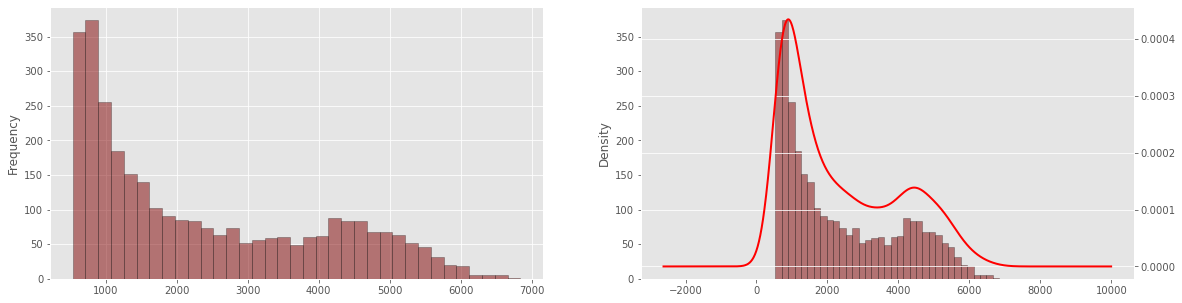

In [7]:
# assign df
df = Extracted_Data.File23_1

# Start by just plotting what we previously grouped!
plt.style.use('ggplot')

fig = plt.figure(figsize=(30,5))

plt.subplot(1,3,1)
nbin, cmin, cmax = [35, 100, 600]
#C = cm(((df.AppliedVoltage-cmin/(cmax-cmin))))
df.data.dI_fit_pA_.plot.hist(bins = nbin, color = plt.cm.get_cmap('jet')((df.AppliedVoltage-cmin)/(cmax-cmin)), edgecolor = 'black', alpha = 0.5)

#plt.subplot(1,3,2)
#df.data.dI_fit_pA_.plot.kde(bw_method=0.2, color = 'red')

plt.subplot(1,3,2)
df.data.dI_fit_pA_.plot.hist(bins = nbin, color = plt.cm.get_cmap('jet')((df.AppliedVoltage-cmin)/(cmax-cmin)), edgecolor = 'black', alpha = 0.5)
df.data.dI_fit_pA_.plot.kde(bw_method=0.2, color = 'red', lw = 2, secondary_y=True)

# remember that visualization is interpretted, it supports evidence.
# plt.ylim([0, 0.06])

plt.show()

### birnbaum saunders model fitting will be used for this sort of data
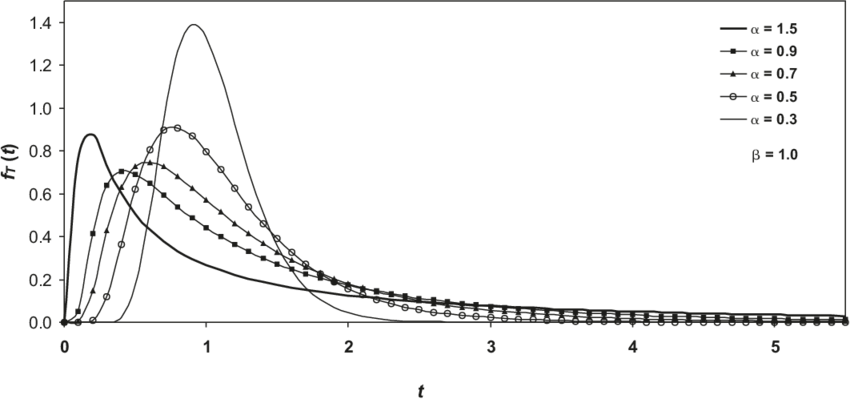!

NameError: name 'beta' is not defined

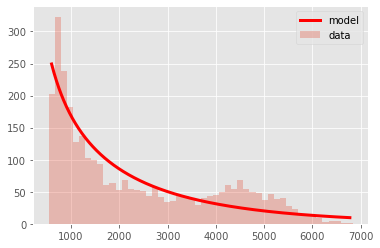

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

#data generation
np.random.seed(123)
data=df.data.dI_fit_pA_
y,x,_=plt.hist(data, 50, alpha=.3, label='data')
x=(x[1:]+x[:-1])/2 # for len(x)==len(y)

#x, y inputs can be lists or 1D numpy arrays

def gauss(x, mu, sigma, A):
    # x = data    # sigma = standard dev    # mu = mean    # A = peak
    return A*np.exp(-(x-mu)**2/2/sigma**2)

def birnbaum(x, c, A):
    return A*(x+1)/(2*c*np.sqrt(2*np.pi*x**3))*np.exp(-(x-1)**2/(2*x*c**2))

def bimodal(x, mu1, sigma1, A1, mu2, sigma2, A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)


expected = (1000, 1000)
params, cov = curve_fit(birnbaum, x, y, expected)
sigma=np.sqrt(np.diag(cov))
x_fit = np.linspace(x.min(), x.max(), 500)
#plot combined...
plt.plot(x_fit, birnbaum(x_fit, *params), color='red', lw=3, label='model')
#...and individual Gauss curves
#plt.plot(x_fit, gauss(x_fit, *params[:3]), color='red', lw=1, ls="--", label='distribution 1')
#plt.plot(x_fit, gauss(x_fit, *params[3:]), color='red', lw=1, ls=":", label='distribution 2')
#and the original data points if no histogram has been created before
#plt.scatter(x, y, marker="X", color="black", label="original data")
plt.legend()
print(pd.DataFrame(data={'params': params, 'beta': beta}, index=birnbaum.__code__.co_varnames[1:]))
plt.show() 

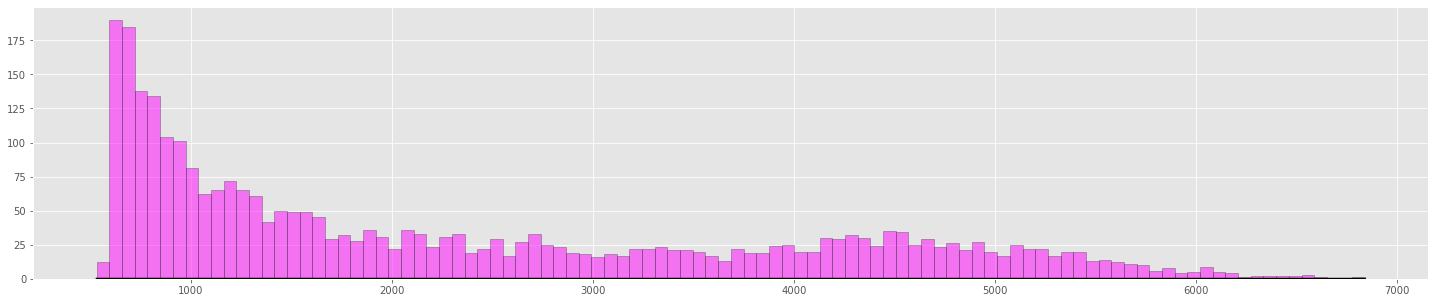

In [9]:
# plotting self-made gaussian fits together
fig = plt.figure(figsize=(25,5))
data = df.data.dI_fit_pA_
y,x,_=plt.hist(data, bins = 100, alpha=.5, label=df.AppliedVoltage, color = plt.cm.get_cmap('cool')((df.AppliedVoltage-cmin)/(cmax-cmin)), edgecolor = 'black')
x_fit = np.linspace(x.min(), x.max(), 500)
plt.plot(x_fit,birnbaum(x_fit,100,500), color = 'black', lw = 2)
#plt.plot(x_fit, gauss(x_fit, 1400,100,80), color='red', lw=1, ls="--", label='distribution 1')
#plt.plot(x_fit, gauss(x_fit, 1800,150,700), color='red', lw=1, ls=":", label='distribution 2')
plt.show()


#df.data.dI_fit_pA_.plot.hist(bins = nbin, color = plt.cm.get_cmap('cool')((df.AppliedVoltage-cmin)/(cmax-cmin)), edgecolor = 'black', alpha = 0.5)

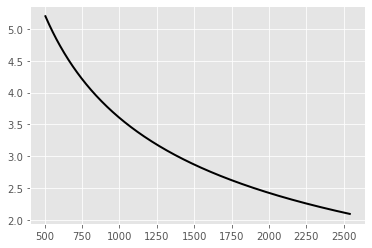

In [298]:
x_fit = np.linspace(x.min(), x.max(), 500)
plt.plot(x_fit,birnbaum(x_fit,100,60000), color = 'black', lw = 2)

## Creating Gaussians to fit on histogram (WORKING)

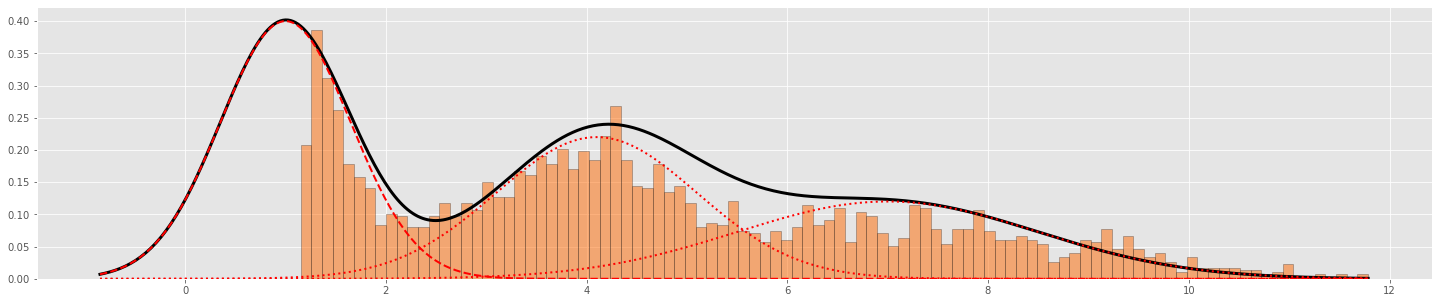

In [24]:
# plotting self-made gaussian fits together
fig = plt.figure(figsize=(25,5))
df = Extracted_Data.File28_1
data = df.data.dI_fit_pA_/df.AppliedVoltage

def gauss(x, mu, sigma, A):
    # x = data    # sigma = standard dev    # mu = mean    # A = peak
    return A*np.exp(-(x-mu)**2/2/sigma**2)

y,x,_=plt.hist(data, bins = 100, alpha=.5, label=df.AppliedVoltage, color = plt.cm.get_cmap('jet')((df.AppliedVoltage-cmin)/(cmax-cmin)), edgecolor = 'black', density = True)
x_fit = np.linspace(x.min()- 2, x.max(), 500)
g1, g2, g3 = gauss(x_fit,1,0.65,0.4), gauss(x_fit,4.1,1,0.22), gauss(x_fit,7,1.5,0.12)
plt.plot(x_fit, g1 + g2 + g3  , color = 'black', lw = 3)
plt.plot(x_fit, g1, color='red', lw=2, ls="--", label='distribution 1')
plt.plot(x_fit, g2, color='red', lw=2, ls=":", label='distribution 2')
plt.plot(x_fit, g3, color='red', lw=2, ls=":", label='distribution 2')
plt.show()


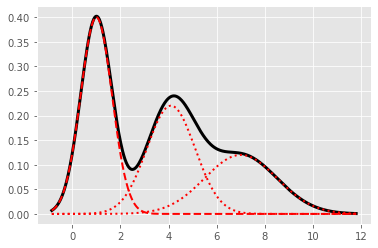

In [26]:
plt.plot(x_fit, g1 + g2 + g3  , color = 'black', lw = 3)
plt.plot(x_fit, g1, color='red', lw=2, ls="--", label='distribution 1')
plt.plot(x_fit, g2, color='red', lw=2, ls=":", label='distribution 2')
plt.plot(x_fit, g3, color='red', lw=2, ls=":", label='distribution 2')

### Distribution area calculations 

In [173]:
from scipy.integrate import trapezoid
a,b,c = trapezoid(g1, x_fit, dx = 0.01), trapezoid(g2, x_fit, dx = 0.01), trapezoid(g3, x_fit, dx = 0.01)
c/(a+b+c)

0.09212397026841744

# Found On Internet
## Bimodal dist: https://stackoverflow.com/questions/35990467/fit-mixture-of-two-gaussian-normal-distributions-to-a-histogram-from-one-set-of

            params     sigma
mu1       1.014589  0.005273
sigma1    0.203826  0.004067
A1      230.654585  3.667409
mu2       1.635225  0.022423
sigma2    0.282690  0.019070
A2       72.621856  2.148459


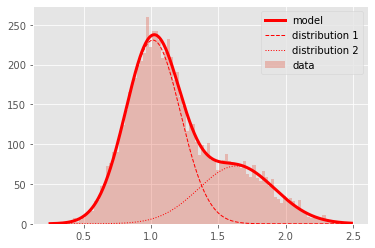

In [231]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

#data generation
np.random.seed(123)
data=np.concatenate((np.random.normal(1, .2, 5000), np.random.normal(1.6, .3, 2500)))
y,x,_=plt.hist(data, 100, alpha=.3, label='data', )
x=(x[1:]+x[:-1])/2 # for len(x)==len(y)

#x, y inputs can be lists or 1D numpy arrays

def gauss(x, mu, sigma, A):
    # x = data    # sigma = standard dev    # mu = mean    # A = peak
    return A*np.exp(-(x-mu)**2/2/sigma**2)

def birnbaum(x, beta, c):
    return (x+1)/(2*c*np.sqrt(2*np.pi*x**3))*np.exp(-(x-1)**2/(2*x*c**2))

def bimodal(x, mu1, sigma1, A1, mu2, sigma2, A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)


#expected = (loc, sigma ,size)
expected = (1, .2, 250, 2, .2, 125)
params, cov = curve_fit(bimodal, x, y, expected)
sigma=np.sqrt(np.diag(cov))
x_fit = np.linspace(x.min(), x.max(), 500)
#plot combined...
plt.plot(x_fit, bimodal(x_fit, *params), color='red', lw=3, label='model')
#...and individual Gauss curves
plt.plot(x_fit, gauss(x_fit, *params[:3]), color='red', lw=1, ls="--", label='distribution 1')
plt.plot(x_fit, gauss(x_fit, *params[3:]), color='red', lw=1, ls=":", label='distribution 2')
#and the original data points if no histogram has been created before
#plt.scatter(x, y, marker="X", color="black", label="original data")
plt.legend()
print(pd.DataFrame(data={'params': params, 'sigma': sigma}, index=bimodal.__code__.co_varnames[1:]))
plt.show() 

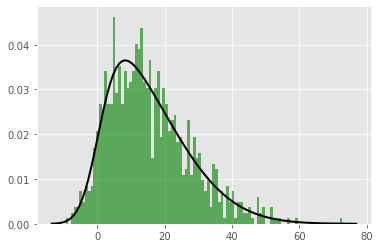

In [322]:
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np

# choose some parameters
a, loc, scale = 5.3, -0.1, 20
# draw a sample
data = stats.skewnorm(a, loc, scale).rvs(1000)
# estimate parameters from sample
ae, loce, scalee = stats.skewnorm.fit(data)
# Plot the PDF.
plt.figure()
plt.hist(data, bins=100, density = True, alpha=0.6, color='g')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.skewnorm.pdf(x,ae, loce, scalee)#.rvs(100)
plt.plot(x, p, 'k', linewidth=2)

In [108]:
(df.AppliedVoltage-cmin)/(cmax-cmin)

0.4

In [174]:
# Where are the higher level events are located ? 
sns.violinplot(x="LevelCount", y="dI_fit_pA_", data=df, 
               split=True, # split across violins
               inner="quart", # show innner stats like mena, IQR, 
               scale="width") # scale the size of the plot by the count within each group
plt.show()


AttributeError: 'FileInfoClass' object has no attribute 'get'

In [17]:
df.LevelCount       

0        1
1        1
2        1
3        1
4        2
        ..
14165    1
14166    1
14167    1
14168    1
14169    1
Name: LevelCount, Length: 14170, dtype: int64